In [5]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.linalg import qr
from functools import partial
from scipy.stats import unitary_group
from sympy import *

In [6]:
# construct an unitary matrix
p = [3 * np.pi / 4, 2 * np.pi * 0.5, 2 * np.pi * 0.625, 3 * np.pi / 4] # 0.011, 0.100, 0.101
p_exp = [np.exp(complex(0,i)) for i in p]
U = np.diag(p_exp)
pd.DataFrame(U.reshape(4,4))

,0,1,2,3
0,-0.707107+0.707107j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j
1,0.000000+0.000000j,-1.0+0.0j,0.000000+0.000000j,0.000000+0.000000j
2,0.000000+0.000000j,0.0+0.0j,-0.707107-0.707107j,0.000000+0.000000j
3,0.000000+0.000000j,0.0+0.0j,0.000000+0.000000j,-0.707107+0.707107j


In [7]:
D = np.diag([3 * np.pi / 4, 2 * np.pi * 0.5, 2 * np.pi * 0.625, 3 * np.pi / 4])
U = np.diag(np.exp(1j * np.diag(D)))

def is_unitary(matrix): # unitarity check
    m_dagger = np.conjugate(matrix.transpose()) 
    identity = np.eye(matrix.shape[0])
    return np.allclose(np.dot(matrix, m_dagger), identity) 

is_unitary(U)

True

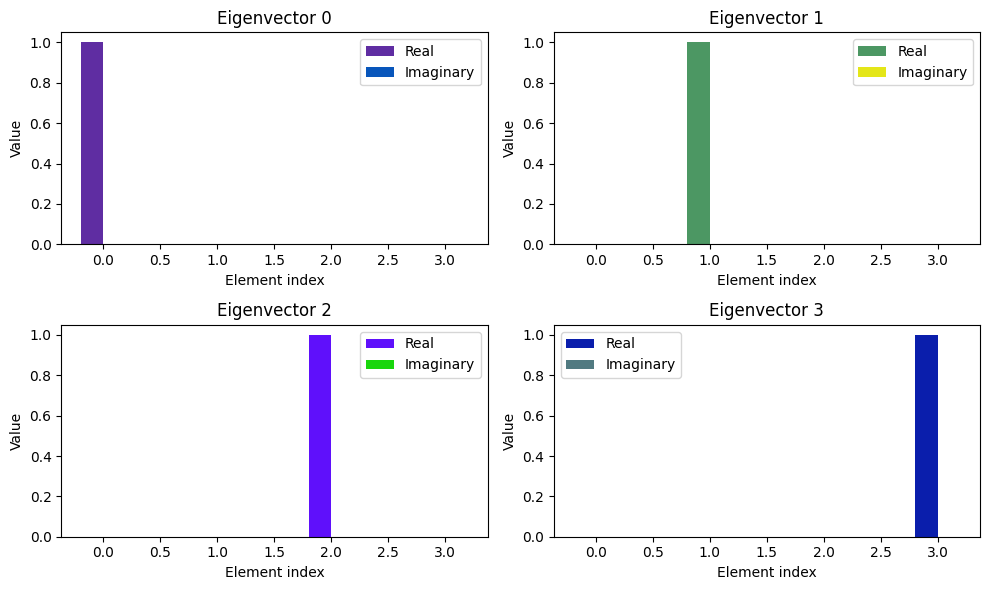

[-0.70710678+7.07106781e-01j -1.        +1.22464680e-16j
 -0.70710678-7.07106781e-01j -0.70710678+7.07106781e-01j]


In [22]:
val, vec = np.linalg.eig(U)

# random color generation
# colors
import random
random.seed(324)
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(60)]

# visualization of eigenvectors
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))  # 4 rows, 2 columns for 8 plots
axes = axes.flatten()  # Flatten the 2D array for easier indexing

# Loop through eigenvectors and plot each one
x = np.arange(0,4,1)
for i in range(4):
    # axes[i].bar(range(4), vec[i], color=colors[i], width=0.5)
    # axes[i].bar(range(4), vec[i], color=colors[i], width=0.5)

    width = 0.2  # Width of each bar
    axes[i].bar(x - width/2, vec[i].real, width=width, color=colors[2*i], label='Real')
    axes[i].bar(x + width/2, vec[i].imag, width=width, color=colors[2*i+1], label='Imaginary')
    axes[i].legend(loc='best')
    axes[i].set_xlabel('Element index')
    axes[i].set_ylabel('Value')
    axes[i].set_title(f'Eigenvector {i}')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

print(val)

In [24]:
pd.DataFrame(val).T

,0,1,2,3
0,-0.707107+0.707107j,-1.0+0.0j,-0.707107-0.707107j,-0.707107+0.707107j


In [23]:
df = pd.DataFrame(vec).T
df.index.name = 'index'
df.rename(columns={0:'vec0', 1:'vec1', 2:'vec2', 3:'vec3'}) # computational bases

,vec0,vec1,vec2,vec3
index,,,,
0,1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
1,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j
2,0.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j
3,0.0+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j


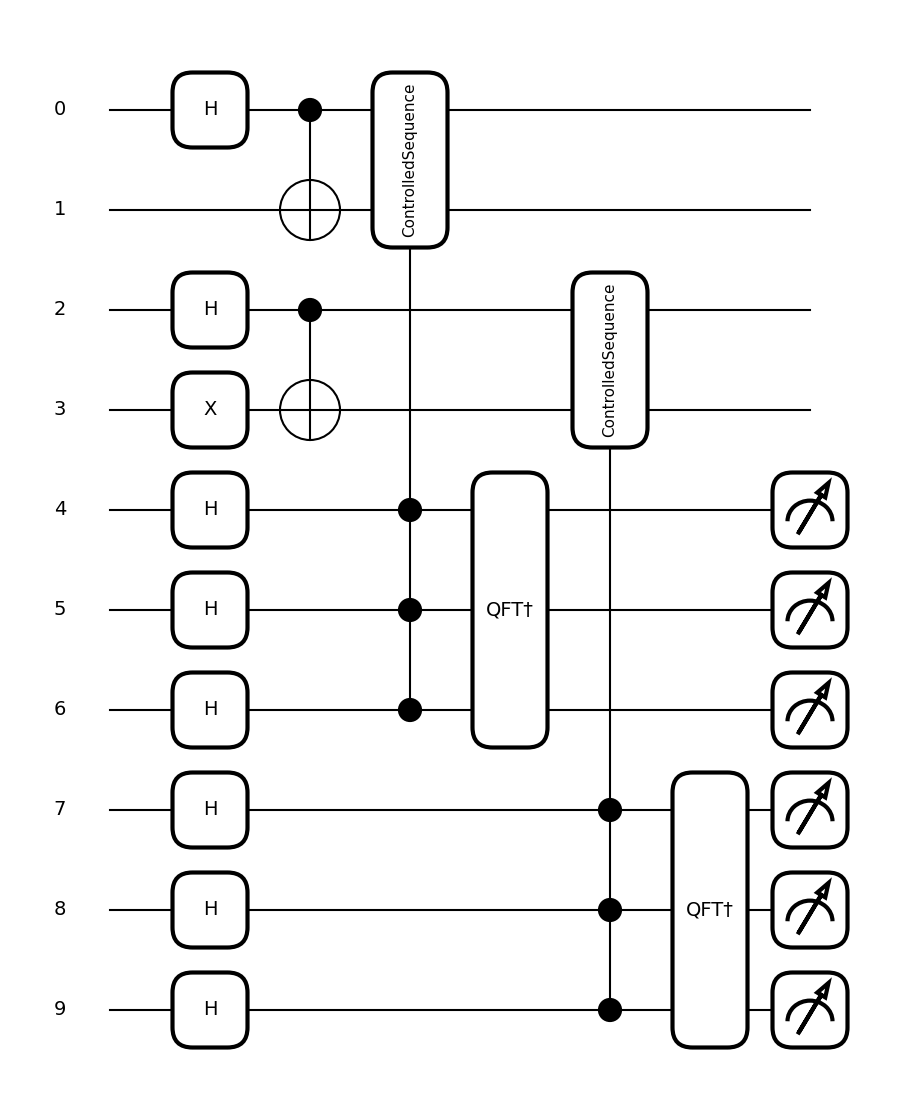

In [8]:
# or do the two operations in parallel and get the result at the same time
dev = qml.device("default.qubit")

@qml.qnode(dev)
def circuit_qpe(estimation_wires):
    # first Bell state
    qml.Hadamard(wires = 0)
    qml.CNOT(wires=[0,1])

    # second Bell state
    qml.PauliX(wires=3)
    qml.Hadamard(wires = 2) 
    qml.CNOT(wires=[2,3])
    
    for wire in estimation_wires:
        qml.Hadamard(wires=wire)

    qml.ControlledSequence(qml.QubitUnitary(U, wires=[0,1]), control=estimation_wires[:3])
    qml.adjoint(qml.QFT)(wires=estimation_wires[:3])

    qml.ControlledSequence(qml.QubitUnitary(U, wires=[2,3]), control=estimation_wires[-3:])
    qml.adjoint(qml.QFT)(wires=estimation_wires[-3:])

    return qml.probs(wires=estimation_wires[:3]), qml.probs(wires=estimation_wires[-3:])

estimation_wires = range(4, 10, 1)

fig, axs = qml.draw_mpl(circuit_qpe)(estimation_wires)

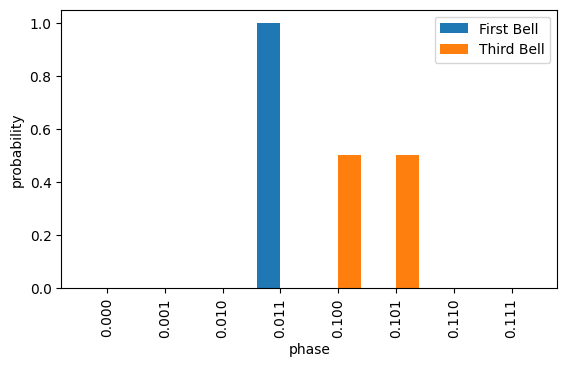

In [9]:
results = circuit_qpe(estimation_wires)

bit_strings = [f"0.{x:0{3}b}" for x in range(len(results[0]))]

x = np.arange(len(bit_strings))  # Numeric positions for bars
width = 0.4  # Width of each bar
plt.bar(x - width/2, results[0], width=width, label='First Bell')
plt.bar(x + width/2, results[1], width=width, label='Third Bell')
plt.xlabel("phase")
plt.ylabel("probability")
plt.xticks(x, bit_strings, rotation="vertical")
plt.subplots_adjust(bottom=0.3)
plt.legend()
plt.show()

In [10]:
# sifing
result = results[0] + results[1]
eig_val = []
for idx, val in enumerate(result):
    if val >= 0.001:
        eig_val.append(bit_strings[idx])
eig_val        

['0.011', '0.100', '0.101']

In [11]:
# float binary to decimal
[int(i) for i in eig_val[0].split('.')[1]]

eig_val_decimal = []
for eig in eig_val:
    temp = [int(i) for i in eig.split('.')[1]]
    temp_decimal = 0
    for idx, val in enumerate(temp):
        if val==1:
            temp_decimal += 1/pow(2, idx+1)
    eig_val_decimal.append(temp_decimal)

# to function
def BinaryToDecimal(array):
    eig_val_decimal = []
    for eig in eig_val:
        # 
        temp = [int(i) for i in eig.split('.')[1]]
        temp_decimal = 0
        for idx, val in enumerate(temp):
            if val==1:
                temp_decimal += 1/pow(2, idx+1)
        eig_val_decimal.append(temp_decimal)
    return eig_val_decimal

print(BinaryToDecimal(eig_val))

[0.375, 0.5, 0.625]


In [12]:
# exponentiation
eig_val_decimal = BinaryToDecimal(eig_val)
eig_val_exp = [np.round(np.exp(complex(0,2*np.pi*i)),6) for i in eig_val_decimal]
eig_val_exp

[(-0.707107+0.707107j), (-1+0j), (-0.707107-0.707107j)]

In [36]:
# U
eig_idx = int(input('Index of a target eigenvalue : '))

eig_val_exp_obj = eig_val_exp.copy()
eig_val_exp_obj.pop(eig_idx)
print(eig_val_exp_obj)

proj_op = 1
for val in eig_val_exp_obj:
    print(pd.DataFrame(np.diag(np.ones(len(U))*val)))
    proj_op *= np.round((U-np.diag(np.ones(len(U))*val)) / (eig_val_exp[eig_idx] - val),6)

pd.DataFrame(proj_op)

# to function
# def ProjectionOperator(eig_val_exp):
#     # get an index input
#     eig_idx = int(input('Index of a target eigenvalue : '))

#     eig_val_exp_obj = eig_val_exp.copy()
#     eig_val_exp_obj.pop(eig_idx)
    
#     proj_op = 1 # turned to a matrix soon
#     for val in eig_val_exp_obj:
#         proj_op *= np.round((U-np.diag(np.ones(len(U))*val)) / (eig_val_exp[eig_idx] - val),6)
    
#     return proj_op

# pd.DataFrame(ProjectionOperator(eig_val_exp))

Index of a target eigenvalue :  1


[(-0.707107+0.707107j), (-0.707107-0.707107j)]
                    0                   1                   2  \
0 -0.707107+0.707107j  0.000000+0.000000j  0.000000+0.000000j   
1  0.000000+0.000000j -0.707107+0.707107j  0.000000+0.000000j   
2  0.000000+0.000000j  0.000000+0.000000j -0.707107+0.707107j   
3  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000+0.000000j  
2  0.000000+0.000000j  
3 -0.707107+0.707107j  
                    0                   1                   2  \
0 -0.707107-0.707107j  0.000000+0.000000j  0.000000+0.000000j   
1  0.000000+0.000000j -0.707107-0.707107j  0.000000+0.000000j   
2  0.000000+0.000000j  0.000000+0.000000j -0.707107-0.707107j   
3  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.000000+0.000000j  
2  0.000000+0.000000j  
3 -0.707107-0.707107j  


,0,1,2,3
0,0.0+0.0j,0.0-0.0j,0.0-0.0j,0.0-0.0j
1,0.0-0.0j,1.0+0.0j,0.0-0.0j,0.0-0.0j
2,0.0-0.0j,0.0-0.0j,0.0+0.0j,0.0-0.0j
3,0.0-0.0j,0.0-0.0j,0.0-0.0j,0.0+0.0j


In [37]:
P_lambda = proj_op
# Verify P^2 = P
is_projection = np.allclose(P_lambda @ P_lambda, P_lambda)
print("Is it a valid projection operator (P^2 = P)?", is_projection)

# Verify if P is Hermitian
is_hermitian = np.allclose(P_lambda.conj().T, P_lambda)
print("Is the projection operator Hermitian?", is_hermitian)

# Compute eigenvalues
eigenvalues_P = np.linalg.eigvals(P_lambda)
print("Eigenvalues of the projection operator:")
print(eigenvalues_P)

Is it a valid projection operator (P^2 = P)? True
Is the projection operator Hermitian? True
Eigenvalues of the projection operator:
[0.+0.j 1.+0.j 0.+0.j 0.+0.j]


In [38]:
# Compute the eigenvalues and eigenvectors of the projection matrix
eigenvalues_P, eigenvectors_P = np.linalg.eig(proj_op)
print(eigenvalues_P)

# Extract the eigenvectors corresponding to eigenvalue ≈ 1 (projection property)
eig_indices = np.where(np.isclose(eigenvalues_P, 1))[0]  # Indices where eigenvalue is close to 1
associated_eigenvectors = eigenvectors_P[:, eig_indices]  # Extract eigenvectors forming the eigenspace

# Display results
print("Eigenvectors associated with the degenerate eigenvalue 3π/4:")
pd.DataFrame(associated_eigenvectors)

[0.+0.j 1.+0.j 0.+0.j 0.+0.j]
Eigenvectors associated with the degenerate eigenvalue 3π/4:


,0
0,0.0+0.0j
1,1.0+0.0j
2,0.0+0.0j
3,0.0+0.0j


In [14]:
# how to find basis vectors of a subspace 1 - SVD
def find_basis(vectors):
    matrix = np.array(vectors).T
    u, s, v = np.linalg.svd(matrix)
    rank = np.sum(s > 1e-10)
    basis = v[:rank]
    return basis

basis = find_basis(proj_op)
print("Pivot columns:")
pd.DataFrame(basis).T

Pivot columns:


,0,1
0,1.0+0.0j,0.0+0.0j
1,0.0+0.0j,0.0+0.0j
2,0.0+0.0j,0.0+0.0j
3,0.0+0.0j,1.0+0.0j


In [21]:
def rounding6(x):
    return round(x,6)

M = Matrix(proj_op)
# pd.DataFrame(M.tolist()).map(rounding6)

# Use sympy.columnspace() method 
M_columnspace = M.columnspace()
pd.DataFrame(([np.array(i.tolist()).flatten() for i in M_columnspace])).T

,0,1
0,1.00000000000000,0
1,0,0
2,0,0
3,0,1.00000000000000


[0 1 0 1] [1 0 1] [0 1 0 1 1 0 1]


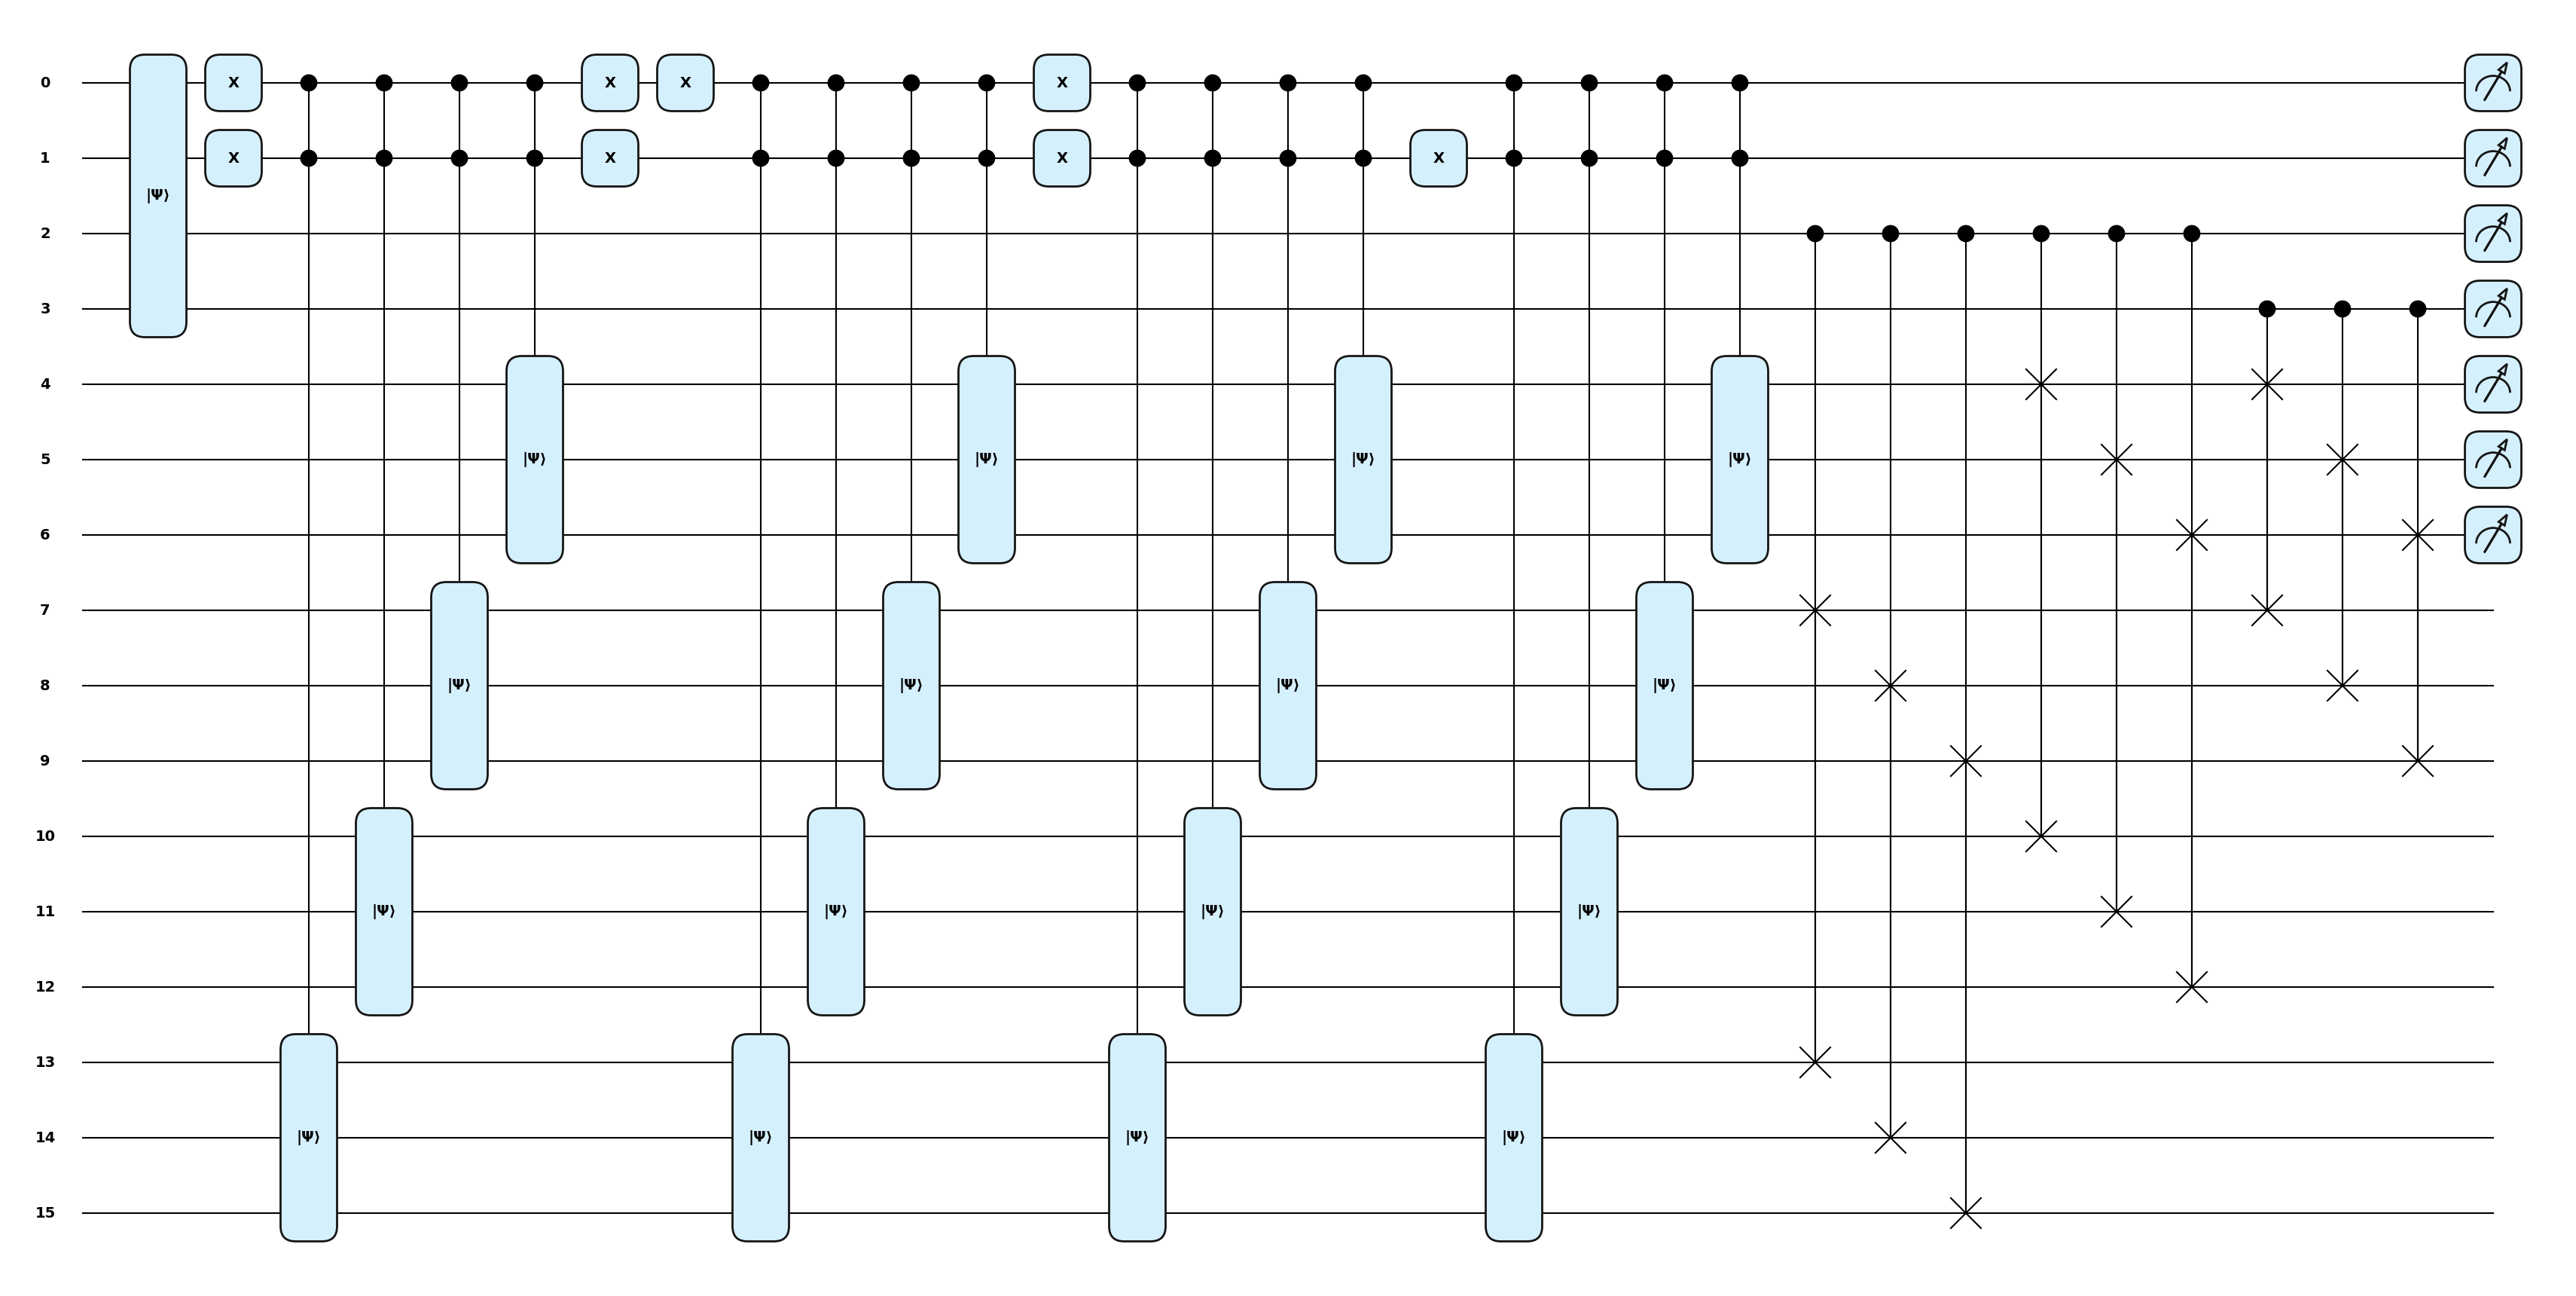

In [78]:
bitstrings = ['100', '000', '000', '000',
             '000', '101', '000', '000',
             '000', '000', '101', '000',
             '000', '000', '000', '101']

control_wires = range(4) # index
target_wires = range(4, 7) # binary value
work_wires = range(7, 16) # auxillary qubits to reduce the circuit depth

# Line added for drawing purposes only
@partial(qml.transforms.decompose, max_expansion=3)
@qml.qnode(qml.device("default.qubit", shots=1))
def circuit(index):
    qml.BasisState(index, wires=control_wires)
    qml.QROM(bitstrings, control_wires, target_wires, work_wires, clean=False)
    return qml.sample(wires=control_wires), qml.sample(wires=target_wires)

print(circuit(5)[0], circuit(5)[1], np.concatenate((circuit(5)[0], circuit(5)[1]))) # index + value

fig, axs = qml.draw_mpl(circuit, style="pennylane")(5)
plt.show()

In [82]:
fig.savefig('qrom.png', bbox_inches='tight')

[0 1 0 1] [1 0 1] [0 1 0 1 1 0 1]


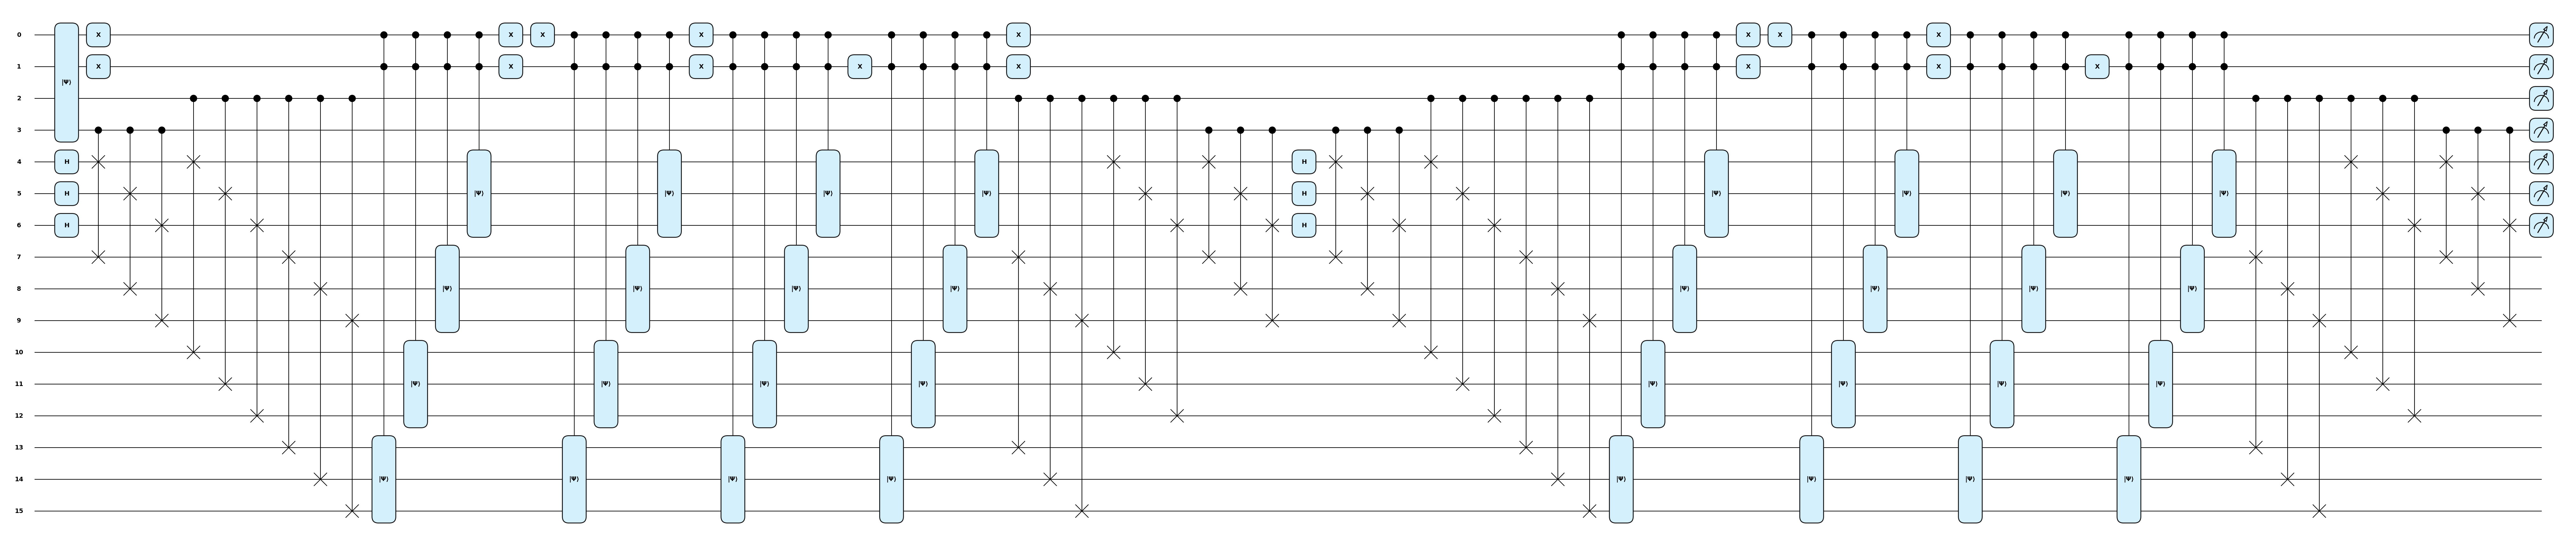

In [83]:
bitstrings = ['100', '000', '000', '000',
             '000', '101', '000', '000',
             '000', '000', '101', '000',
             '000', '000', '000', '101']

control_wires = range(4) # index
target_wires = range(4, 7) # binary value
work_wires = range(7, 16) # auxillary qubits to reduce the circuit depth

# Line added for drawing purposes only
@partial(qml.transforms.decompose, max_expansion=3)
@qml.qnode(qml.device("default.qubit", shots=1))
def circuit(index):
    qml.BasisState(index, wires=control_wires)
    qml.QROM(bitstrings, control_wires, target_wires, work_wires, clean=True)
    return qml.sample(wires=control_wires), qml.sample(wires=target_wires)

print(circuit(5)[0], circuit(5)[1], np.concatenate((circuit(5)[0], circuit(5)[1]))) # index + value

fig, axs = qml.draw_mpl(circuit, style="pennylane")(5)
plt.show()

In [84]:
fig.savefig('qrom_clean.png', bbox_inches='tight')

In [80]:
newBasis = []
for i in range(16):
    newBasis.append(np.concatenate((circuit(i)[0], circuit(i)[1])).tolist())
newBasis

[[0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 1, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0],
 [0, 0, 1, 1, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0],
 [0, 1, 0, 1, 1, 0, 1],
 [0, 1, 1, 0, 0, 0, 0],
 [0, 1, 1, 1, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 0, 0, 0],
 [1, 0, 1, 0, 1, 0, 1],
 [1, 0, 1, 1, 0, 0, 0],
 [1, 1, 0, 0, 0, 0, 0],
 [1, 1, 0, 1, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 0, 1]]

In [81]:
# superposition state from QROM
n = len(newBasis)
coeffs = np.sqrt(np.ones(n)/n)
wires = range(7)
work_wire = 7

dev = qml.device('default.qubit')
@qml.qnode(dev)
def circuit():
    qml.Superposition(coeffs, newBasis, wires, work_wire)
    return qml.probs(wires)

circuit()

array([0.    , 0.    , 0.    , 0.    , 0.0625, 0.    , 0.    , 0.    ,
       0.0625, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.0625, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.0625, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.0625, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.0625, 0.    , 0.    ,
       0.0625, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.0625, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.0625, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.0625, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.0625, 0.    , 0.    ,
       0.0625, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.0625, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.0625, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
      

In [91]:
# arithmetic operation OutAdder
def state_to_decimal(binary_array):
    # Convert a binary array to a decimal number
    return sum(bit * (2 ** idx) for idx, bit in enumerate(reversed(binary_array)))
    
x1 = state_to_decimal([1,0,1])
x2 = state_to_decimal([1,0,0])
mod = 2

x_wires= range(3)
y_wires= range(3,6,1)
output_wires = range(6,9,1)
work_wires = [9,10]

dev = qml.device("default.qubit", shots=1)
@qml.qnode(dev)
def circuit():
    qml.BasisEmbedding(x1, wires=x_wires)
    qml.BasisEmbedding(x2, wires=y_wires)
    qml.adjoint(qml.OutAdder(x_wires, y_wires, output_wires, mod, work_wires))
    return qml.sample(wires=output_wires)

circuit()

array([0, 0, 1], dtype=int64)

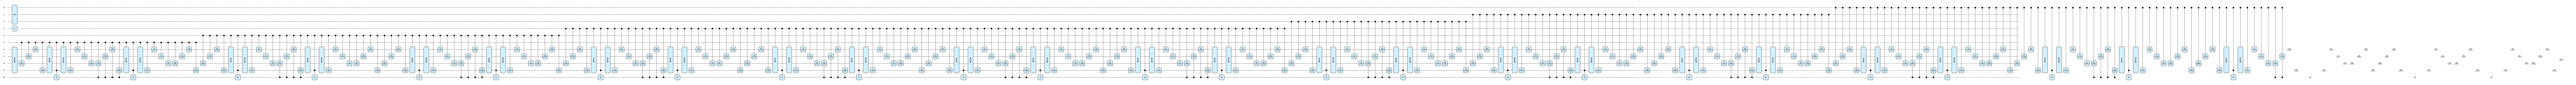

In [92]:
fig, _ = qml.draw_mpl(circuit, decimals = 2, style = "pennylane", level='device')()

In [145]:
x = np.array([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
qml.math.partial_trace(x, indices=[0])

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]])

In [151]:
# Python program to add two binary numbers.

# Driver code
# Declaring the variables
a = "1101"
b = "100"

# Calculating binary value using function
sum = bin(int(a, 2) - int(b, 2))

# Printing result
print(sum)
print(sum[2:])

0b1001
1001


In [3]:
# qml.QROMStatePreparation

probs_vector = np.array([0.5, 0., 0.25, 0.25])

dev = qml.device("default.qubit", wires = 6)

wires = qml.registers({"work_wires": 1, "prec_wires": 3, "state_wires": 2})

@qml.qnode(dev)
def circuit():
    qml.QROMStatePreparation(
        np.sqrt(probs_vector), wires["state_wires"], wires["prec_wires"], wires["work_wires"]
    )
    return qml.probs(wires["state_wires"])

circuit()

array([0.5 , 0.  , 0.25, 0.25])

Matplotlib is building the font cache; this may take a moment.


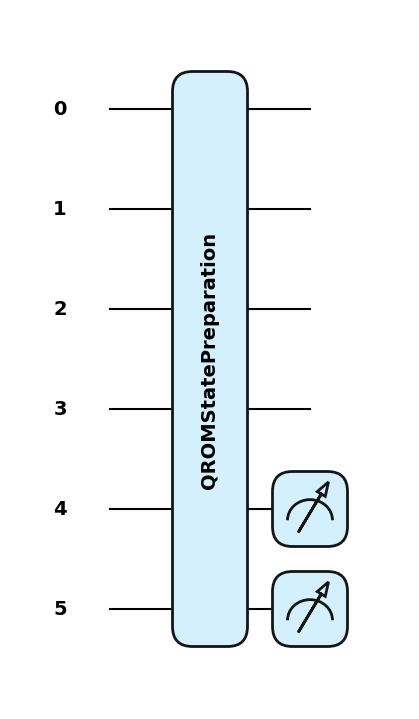

In [5]:
fig, axs = qml.draw_mpl(circuit, style="pennylane")()